# Hyperparameter tunning of ds4f.DeepScanner for VSL Fault Detection Problem

**License**

```MIT License
Copyright (c) 2023 / HP-SCDS Observatorio 2021-2022 / Máster Data-Science UC /
Diego García Saiz / Javier Alejandro Cuartas Micieces / 2021-2022 / 
DeepScan4Failure

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.



Hyperparameter tunning was performed on this dataset following these steps:

* Splitting into training and validation sets applying k-fold cross-validation in a custom way over the data labeled as normal (semi-supervised approach).


* Scaling according to the previously selected training set.


* Mean MCC (Mathew's Correlation Coefficient) calculation as the value returned by the objective function to the bayesian optimizer.

### ds4f Package loading

In [1]:
import sys
import os
sys.path.append(os.getcwd()+"/src")
import ds4f

### Scaling

Function definition. It generates an 'ename' file with all scaled data.

In [2]:

def scale(ename,scaledfile,idtrain,idvalidation,mdj,nfeatures,path,dfm):
    f_names=["h0","lenpksd","pksdov0","pksdbe0","meanprat","stdprat","maxprat","minprat","per01prat","per05prat","per25prat","per50prat","per75prat","per95prat","per99prat","meanpksd","stdpksd","max-minpksd","meanpratr","stdpratr","maxpratr","minpratr","per01pratr","per05pratr","per25pratr","per50pratr","per75pratr","per95pratr","per99pratr","meanpksdr","stdpksdr","max-minpksdr","posx","stdpksdp"]
    f_ext=[c+el for c in ["per01_","per05_","per25_","per50_","per75_","per95_","per99_","mean_","std_","min_","max_"] for el in f_names ]
    f_ads=["lenpx"]
    nwindows=8
    full=list()
    fullw=["wph_"+str(el) for el in np.arange(nwindows)]
    fulla=["phase0","target","phase"]
    for nw in range(nwindows+1):
      if nw!=nwindows:
        full.append([wel+"_w"+str(nw) for wel in fullw])
      full.append([xt_el+"_w"+str(nw) for xt_el in f_ext])
      full.append([ds_el+"_w"+str(nw) for ds_el in f_ads])
    full.append(fulla)
    c_names=[f for sl in full for f in sl]

    df = pd.DataFrame(columns=c_names)

    rws=list()
    idlst=idtrain.to_list()+idvalidation.to_list()
    for k in np.array(idlst):
      with h5py.File(path+ename, "r") as f:
        dg=f["general/"+str(k)]
        rdg=dg[:,:]
        rdg=rdg.tolist()[0]
      rdg=rdg+[dfm.loc[k,"target"],dfm.loc[k,"phase"]]
      rws.append(rdg)

    dfb = pd.DataFrame(rws, columns = c_names,index=idtrain.to_list()+idvalidation.to_list())

    ix=['min0','min1','min2','max0','max1','max2','mean0','mean1','mean2','var0','var1','var2']
    dfscale = pd.DataFrame(columns=c_names, index=ix)
    trainfiltered=dfb.iloc[dfb.index.isin(idtrain.tolist()),:]
    for el in ix:
      phasefiltered=trainfiltered.loc[trainfiltered.loc[:,"phase"]==int(el[-1:]),:]
      varv=phasefiltered.min(axis=0) if "min" in el else phasefiltered.max(axis=0) if "max" in el else phasefiltered.mean(axis=0) if "mean" in el else phasefiltered.var(axis=0)
      dfscale.loc[el,:] = varv
    del phasefiltered,varv

    cols=[el for el in dfb.columns if all(["wph_" not in el,el not in ["target","phase"]])]
    negcols=np.concatenate([["target","phase"],[el for el in dfb.columns if "wph_" in el]]).tolist()
    dfscaled=pd.DataFrame(columns=c_names, index=dfb.index)
    for i in range(nfeatures):
      refmin="min"+str(i)
      refmax="max"+str(i)
      dfscaled.loc[dfb.loc[:,"phase"]==i,cols]=dfb.loc[dfb.loc[:,"phase"]==i,cols].apply(lambda x: (x-dfscale.loc[refmin,cols])/(dfscale.loc[refmax,cols]-dfscale.loc[refmin,cols]), axis=1,result_type='broadcast').astype(np.float64)
    dfscaled.loc[:,negcols]=dfb.loc[:,negcols]

    fcol=[el for el in dfb.columns if el not in ["phase","target"]]
    with h5py.File(path+scaledfile, "w") as f:
      f.create_group("general")
      f.flush()

    for k in dfscaled.index:
      with h5py.File(path+scaledfile, "a") as f:
        f.create_dataset("general/"+str(k), shape=(1,len(fcol)),dtype="f8")
        f.flush()
      with h5py.File(path+scaledfile, "a") as f:
        dg=f["general/"+str(k)]
        dg[:,:]=dfscaled.loc[k,fcol]
        f.flush()

## DeepScanner parameter optimization


In [3]:
import datetime
import numpy as np
import pandas as pd
import h5py
import json
import torch

#### **GPyOpt Optimization** 

In [8]:
#Global parameters: Non optimized

path="/home/ubuntu1/cdir/"
directorytb='/home/ubuntu1/cdir/runs/'
labels_fpth=path+"data/metadata_train.csv"
ename="data/curatedset.h5"

nk=1
nfeatures=3
batch_size=8
epochs=2
lim_val_size=0.5
limlossreadsepochtb=1
early_stopping=2
optimizer = "Adam"
with h5py.File(path+ename, "r") as f:
  nr=pd.DataFrame(f["general/"+str(0)][:])
nrw=nr.shape[1]
input_size=(nfeatures*nrw)

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
mdj=0
max_time=3600
num_acq_points=1
max_iter=3

Objective function definition. This will be optimized with GpyOpt to get the best hyperparameters.

In [9]:
def objective_function(params):

    global mdj, timestamp,input_size,nrw,optimizer,early_stopping,limlossreadsepochtb,\
                lim_train_size,lim_val_size,epochs,nfeatures,batch_size,nk,\
                path,directorytb,labels_fpth,ename

    latent_size=int(params[0][0])
    encdec_size=int(params[0][1])
    beta=params[0][2]
    lr=params[0][3]

    dfm=dfm = pd.read_csv(labels_fpth)
    hidden_sizes=np.linspace(input_size,latent_size,encdec_size).tolist()
    model = {"input_size":input_size,"z_samplesz":encdec_size,"hidden_sizes":[int(i) for i in hidden_sizes]+[latent_size]}
    opt_params={"lr":lr, "betas":(0.9, 0.999), "weight_decay":0, "eps":1e-8,"amsgrad":False, "maximize":False, "foreach":None,"capturable":False}#"Adam"

    #Random shuffle
    idf1=dfm.loc[dfm.loc[:,'target']==1,:]
    id1=idf1["id_measurement"].unique().copy()
    idf0=dfm.loc[dfm['id_measurement'].apply(lambda x: x not in id1),:]
    id0t=idf0['id_measurement'].unique().copy()
    np.random.shuffle(id0t)

    #K-fold splitting
    MCCv=list()
    kflen=int(id0t.shape[0]/nk) if (int(id0t.shape[0]/nk)<id1.shape[0]) else id1.shape[0]

    for k in range(nk):
        id0k=id0t[(k*kflen):((k+1)*kflen)]
        id=np.concatenate([id0k,id1])
        np.random.shuffle(id)
        idv=np.array(pd.Series(id).apply(lambda x: dfm.loc[dfm['id_measurement']==x,:].to_dict("records"))).sum()
        idxvalidation=pd.DataFrame(idv).loc[:,['id_measurement','signal_id','target']].reset_index(drop=True)

        idtrain=dfm.loc[(dfm["signal_id"].isin(idxvalidation["signal_id"]).tolist()==np.repeat(False,dfm.shape[0])).tolist(),["id_measurement","signal_id"]].reset_index()
        idtrain=idtrain.loc[:,"signal_id"]
        idvalidation=idxvalidation.loc[:,"signal_id"]
        lbvalidation=idxvalidation.loc[:,"target"]
        lstfullsig=[144,
             145,
             146,
             1740,
             1741,
             1742,
             2571,
             2572,
             2573,
             3564,
             3565,
             3566,
             5643,
             5644,
             5645,
             6396,
             6397,
             6398,
             7905,
             7906,
             7907,
             8691,
             8692,
             8693]

        idtrain=idtrain.loc[~idtrain.isin(lstfullsig)]
        f_valref=idvalidation.isin(lstfullsig)
        idvalidation=idvalidation.loc[~f_valref]
        lbvalidation=lbvalidation.loc[~f_valref]

        filep="scaled_"+str(mdj)+".h5"

        idtrain=idtrain.reset_index(drop=True)
        idvalidation=idvalidation.reset_index(drop=True)
        lbvalidation=lbvalidation.reset_index(drop=True)

        scale(ename,"data/"+filep,idtrain,idvalidation,mdj,nfeatures,path,dfm)

        #DeepScanner instance

        detector=ds4f.DeepScanner(model,path,
                             load=False,savenew=True,cname=str(mdj)+"trainedScanner")

        #DeepScanner training

        detector.fit(filep,idtrain,nfeatures,
                     batch_size=batch_size,epochs=epochs,
                     beta=beta,early_stopping=early_stopping,
                     optimizer=optimizer,optimizer_params=opt_params,
                     idvalidation=idvalidation,lbvalidation=lbvalidation,thres_l=np.arange(0.15,0.6,0.001).tolist(),
                     lim_val_size=lim_val_size, limlossreadsepochtb=limlossreadsepochtb,
                     directorytb=directorytb)

        with open('{}savedmodels.json'.format("models/"+str(mdj)+"trainedScanner_"), 'r') as f:
            g=json.load(f)

        with open(detector.modelspath+detector.cname+"_savedmodels.json", 'r') as f:
            g=json.load(f)
            MCCv.append(g[0][list(g[0].keys())[0]]["v_mccv"])

        del g,detector,idv,idxvalidation,idvalidation,lbvalidation,idtrain
        os.remove(path+"data/"+filep)
        mdj=mdj+1

    #Hyperparameter logging.

    if os.path.exists(path+"logs/_hyperparametertunning_{}.log".format(timestamp)):
        logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "a")
    else:
        logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "w")
    logft.write("**********************************************************************\n")
    logft.write("latent_size:{},encdec_size:{}, beta:{}, lr:{}.".format(latent_size,encdec_size,beta,lr))
    logft.write("\n**********************************************************************\n")
    logft.write("Mean: {}.".format(np.mean(MCCv)))
    logft.write("\nStandard Deviation: {}.".format(np.std(MCCv)))
    logft.write("\n********************************\n")
    logft.close()

    return np.mean(MCCv)

Bayesian Hyperparameter optimization with GPyOpt library.

In [ ]:
import GPyOpt

#Optimized variables 

encdec_size_tuple=tuple(np.arange(3,6,2).astype(int))
latent_size_tuple=tuple(np.arange(5,1000,1).astype(int))

space=[{'name':'latent_size','type':'discrete','domain':latent_size_tuple},
       {'name':'encdec_size','type':'discrete','domain':encdec_size_tuple},
       {'name':'beta','type':'continuous','domain':(0.5,10)},
       {'name':'lr','type':'continuous','domain':(0.00001,0.01)}]

optimizerh=GPyOpt.methods.BayesianOptimization(f=objective_function,domain=space, initial_design_numdata=5,num_acq_points=num_acq_points)
optimizerh.run_optimization(max_iter=max_iter,max_time=max_time)

if os.path.exists(path+"logs/_hyperparametertunning_{}.log".format(timestamp)):
    logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "a")
else:
    logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "w")
logft.write("\n\n**********************************************************************\n")
logft.write("**********************************************************************\n")
logft.write("BEST SCORE'S HYPERPARAMETERS\n")
logft.write("**********************************************************************\n")
logft.write("latent_size:{},encdec_size:{}, beta:{}, lr:{}.".format(optimizerh.x_opt[0],optimizerh.x_opt[1],optimizerh.x_opt[2],optimizerh.x_opt[3]))
logft.close()

#### **bayesian-optimization Optimization**

In [4]:
#Global parameters: Non optimized

path="/home/ubuntu1/cdir/"
directorytb='/home/ubuntu1/cdir/runs/'
labels_fpth=path+"data/metadata_train.csv"
ename="data/curatedset.h5"

nk=3
nfeatures=3
batch_size=8
epochs=200
lim_val_size=0.5
limlossreadsepochtb=4
early_stopping=3
optimizer = "Adam"
lr=0.0005
encdec_size=3

with h5py.File(path+ename, "r") as f:
  nr=pd.DataFrame(f["general/"+str(0)][:])
nrw=nr.shape[1]
input_size=(nfeatures*nrw)

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
mdj=0
max_time=3600
max_iter=3

Objective function definition. This will be optimized with bayesian-optimization library to get the best hyperparameters.

In [5]:
def objective_function(beta,latent_size):

    global mdj, timestamp,input_size,nrw,optimizer,early_stopping,limlossreadsepochtb,\
                lim_train_size,lim_val_size,epochs,nfeatures,batch_size,nk,\
                path,directorytb,labels_fpth,ename,encdec_size,lr

    latent_size=int(latent_size)
    encdec_size=encdec_size
    beta=beta
    lr=lr

    dfm=dfm = pd.read_csv(labels_fpth)
    hidden_sizes=np.linspace(input_size,latent_size,encdec_size).tolist()
    model = {"input_size":input_size,"z_samplesz":encdec_size,"hidden_sizes":[int(i) for i in hidden_sizes]+[latent_size]}
    opt_params={"lr":lr, "betas":(0.9, 0.999), "weight_decay":0, "eps":1e-8,"amsgrad":False, "maximize":False, "foreach":None,"capturable":False}#"Adam"

    #Random shuffle
    idf1=dfm.loc[dfm.loc[:,'target']==1,:]
    id1=idf1["id_measurement"].unique().copy()
    idf0=dfm.loc[dfm['id_measurement'].apply(lambda x: x not in id1),:]
    id0t=idf0['id_measurement'].unique().copy()
    np.random.shuffle(id0t)

    #K-fold splitting
    MCCv=list()
    kflen=int(id0t.shape[0]/nk) if (int(id0t.shape[0]/nk)<id1.shape[0]) else id1.shape[0]

    for k in range(nk):
        id0k=id0t[(k*kflen):((k+1)*kflen)]
        id=np.concatenate([id0k,id1])
        np.random.shuffle(id)
        idv=np.array(pd.Series(id).apply(lambda x: dfm.loc[dfm['id_measurement']==x,:].to_dict("records"))).sum()
        idxvalidation=pd.DataFrame(idv).loc[:,['id_measurement','signal_id','target']].reset_index(drop=True)
#         idxvalidation=pd.DataFrame(idv).loc[:,['id_measurement','signal_id','target']].reset_index(drop=True)

        idtrain=dfm.loc[(dfm["signal_id"].isin(idxvalidation["signal_id"]).tolist()==np.repeat(False,dfm.shape[0])).tolist(),["id_measurement","signal_id"]].reset_index()
        idtrain=idtrain.loc[:,"signal_id"]
        idvalidation=idxvalidation.loc[:,"signal_id"]
        lbvalidation=idxvalidation.loc[:,"target"]
        lstfullsig=[144,
             145,
             146,
             1740,
             1741,
             1742,
             2571,
             2572,
             2573,
             3564,
             3565,
             3566,
             5643,
             5644,
             5645,
             6396,
             6397,
             6398,
             7905,
             7906,
             7907,
             8691,
             8692,
             8693]

        idtrain=idtrain.loc[~idtrain.isin(lstfullsig)]
        f_valref=idvalidation.isin(lstfullsig)
        idvalidation=idvalidation.loc[~f_valref]
        lbvalidation=lbvalidation.loc[~f_valref]

        filep="scaled_"+str(mdj)+".h5"

        idtrain=idtrain.reset_index(drop=True)
        idvalidation=idvalidation.reset_index(drop=True)
        lbvalidation=lbvalidation.reset_index(drop=True)

        scale(ename,"data/"+filep,idtrain,idvalidation,mdj,nfeatures,path,dfm)

        #DeepScanner instance

        detector=ds4f.DeepScanner(model,path,
                             load=False,savenew=True,cname=str(mdj)+"trainedScanner")

        #DeepScanner training

        detector.fit(filep,idtrain,nfeatures,
                     batch_size=batch_size,epochs=epochs,
                     beta=beta,early_stopping=early_stopping,
                     optimizer=optimizer,optimizer_params=opt_params,
                     idvalidation=idvalidation,lbvalidation=lbvalidation,thres_l=np.arange(0.15,0.6,0.001).tolist(),
                     lim_val_size=lim_val_size, limlossreadsepochtb=limlossreadsepochtb,
                     directorytb=directorytb)

        with open('{}savedmodels.json'.format("models/"+str(mdj)+"trainedScanner_"), 'r') as f:
            g=json.load(f)

        with open(detector.modelspath+detector.cname+"_savedmodels.json", 'r') as f:
            g=json.load(f)
            MCCv.append(g[0][list(g[0].keys())[0]]["v_mccv"])

        del g,detector,idv,idxvalidation,idvalidation,lbvalidation,idtrain
        os.remove(path+"data/"+filep)
        mdj=mdj+1

    #Hyperparameter logging.

    if os.path.exists(path+"logs/_hyperparametertunning_{}.log".format(timestamp)):
        logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "a")
    else:
        logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "w")
    logft.write("**********************************************************************\n")
    logft.write("latent_size:{}, beta:{}.".format(latent_size,beta))
    logft.write("\n**********************************************************************\n")
    logft.write("Mean: {}.".format(np.mean(MCCv)))
    logft.write("\nStandard Deviation: {}.".format(np.std(MCCv)))
    logft.write("\n********************************\n")
    logft.close()

    return np.mean(MCCv)

Bayesian Hyperparameter optimization with BayesianOptimization library.

In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

#Optimized variables 

space={'latent_size':(20,250),
       'beta':(1,10)}

logger=JSONLogger(path='./logs.log')
optimizerh=BayesianOptimization(f=objective_function,pbounds=space)
optimizerh.subscribe(Events.OPTIMIZATION_STEP,logger)
optimizerh.maximize(n_iter=max_iter,init_points=5) #Despite the method name, It will minimize by default

if os.path.exists(path+"logs/_hyperparametertunning_{}.log".format(timestamp)):
    logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "a")
else:
    logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "w")
logft.write("\n\n**********************************************************************\n")
logft.write("**********************************************************************\n")
logft.write("BEST SCORE'S HYPERPARAMETERS\n")
logft.write("**********************************************************************\n")
logft.write("latent_size:{},beta:{}.".format(optimizerh.max['params']['latent_size'],optimizerh.max['params']['beta']))
logft.close()

You can also reload a previously trained hyperparameter bayesian-optimization library optimization process that stopped due to problems regarding bugs in the code, power cuts...

In [66]:
# from bayes_opt.util import load_logs

# #We change some of the fixed variables since results were not as good as expected, and not as fast as expected either:

# nk=1
# lr=0.0001

# #Optimized variables 

# space={'latent_size':(20,250),
#        'beta':(1,10)}

# optimizerh=BayesianOptimization(
#     f=objective_function,
#     pbounds=space,
#     verbose=2,
#     random_state=7
# )

# logger=JSONLogger(path='./logs_rep1.log')
# optimizerh.subscribe(Events.OPTIMIZATION_STEP,logger)
# optimizerh.maximize(n_iter=max_iter,init_points=5) #Despite the method name, It will minimize by default

# if os.path.exists(path+"logs/_hyperparametertunning_{}.log".format(timestamp)):
#     logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "a")
# else:
#     logft = open(path+"logs/_hyperparametertunning_{}.log".format(timestamp), "w")
# logft.write("\n\n**********************************************************************\n")
# logft.write("**********************************************************************\n")
# logft.write("BEST SCORE'S HYPERPARAMETERS\n")
# logft.write("**********************************************************************\n")
# logft.write("latent_size:{},beta:{}.".format(optimizerh.max['params']['latent_size'],optimizerh.max['params']['beta']))
# logft.close()


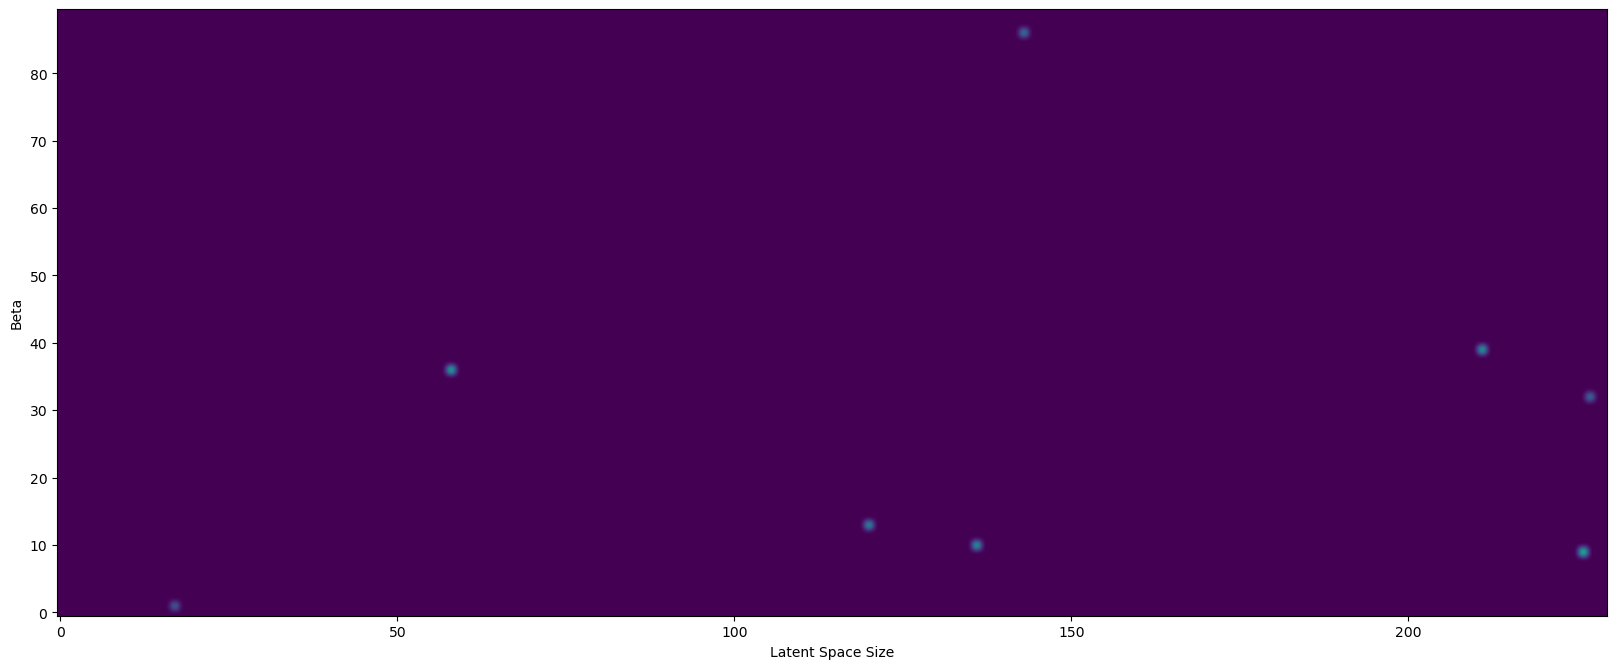

In [65]:
import numpy as np
import matplotlib.pyplot as plt
mp=list()
lp=list()
xp=list()
for idr in optimizerh.res:
    mp.append(idr["target"])
    xp.append(idr["params"]["beta"])
    lp.append(idr["params"]["latent_size"])
mp=pd.Series(np.array(mp)).map(lambda x: round(x,3))
xp=pd.Series(np.array(xp)).map(lambda x: round(x,1))
lp=pd.Series(np.array(lp)).map(lambda x: int(x))
xid=list(np.arange(space["latent_size"][0],space["latent_size"][1],1))
yid=list(np.around(np.arange(space["beta"][0],space["beta"][1],0.1),decimals=1))
hist=np.zeros([len(yid),len(xid)])

for iel,rel in enumerate(mp):
    hist[yid.index(round(xp[iel],1)),xid.index(lp[iel])]=rel

fig,ax=plt.subplots(figsize=(20,10))
ax.imshow(hist,origin='lower',interpolation='quadric')
# ax.set_xticks(xid)
# ax.set_yticks(yid)
ax.set_xlabel("Latent Space Size")
ax.set_ylabel("Beta")
plt.show()

# Final Model Building

 Training with the full training dataset from the VSB Fault Detection Challenge in Kaggle and use of _train.py_ and _predict.py_.

In [ ]:
!python train.py --path "/home/ubuntu1/cdir/proj/" --data_file "scaled_3.h5" --training_ids_file "idtrain_2.csv" --validation_ids_file "idvalid_2.csv" --validation_lab_file "lbvalid_2.csv" --save_new True --output_file "intento_1" --scanner_params_file "trainedFromShell.json"

In [ ]:
!python predict.py --path "/home/ubuntu1/cdir/proj/" --data_file "scaled_3.h5" --pr_loss True --ths 0.31 --load "model_intento_1_20230521_165922.pt" --config "intento_1_savedmodels.json" --output_file "results_predict.csv" 

### Tensorboard results

If all folders but the one corresponding to the best hiperparameters are removed from the runs/ directory, It will be possible to use the following bash line to get the learning curves and the performance metrics related to the model linked to the *--logdir* argument folder.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="/home/ubuntu1/cdir/runs"
!tensorboard dev upload \
  --logdir "/home/ubuntu1/cdir/runs" \
  --name "DL4_1" \
  --description "first_t" \
  --one_shot

#See 127.0.0.1:6006 

TensorFlow installation not found - running with reduced feature set.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/home/ubuntu1/cdir/runs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

<a name="Bibliography"></a>
# __Bibliography__/__Webgraphy__

* Addison H, Dane S, Vantuch T. _Power Line Fault Detection_ (2018). Kaggle [Online]. Available: https://www.kaggle.com/competitions/vsb-power-line-fault-detection/data.



* An J, Cho S. “Variational Autoencoder based Anomaly Detection using Reconstruction Probability”. _Special Lecture on IE_. 2015. Vol. 2. No. 1. pp. 1–18.
https://www.semanticscholar.org/paper/Variational-Autoencoder-based-Anomaly-Detection-An-Cho/061146b1d7938d7a8dae70e3531a00fceb3c78e8?p2df [Accesed: Apr. 2023].



* Higgins I, Matthey L, Pal A, Burgess C, Glorot X, Botvinick M, Mohamed S, Lerchner A. “beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework”. _International Conference on Learning Representations (ICLR)_. 2017. [Online]. Available:
https://openreview.net/forum?id=Sy2fzU9gl [Accessed: Dec. 2021].



* Kingma DP, Welling M. “Auto-Encoding Variational Bayes”. arXiv:1312.6114v11 [stat.ML]. Dec 2013. [Online].  Available at:
https://arxiv.org/abs/1312.6114 [Accessed: Dec. 2022].



* Pytorch, _Pytorch Tutorials_ (2022). Pytorch. Accessed: 2021 Dec 28 [Online]. Available: https://pytorch.org/tutorials/ [Accessed: Apr. 2022].



* Pytorch, _Pytorch Documentation_ (2022). Pytorch. Accessed: 2021 Dec 28 [Online]. Available: https://pytorch.org/docs/stable/index.html [Accessed: Apr. 2022].